In [7]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [8]:
houses_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [9]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [10]:
# These are columns with missing values in data frame we need to analyze
houses_df.columns[houses_df.isnull().any()]

Index(['lotfrontage', 'alley', 'masvnrtype', 'masvnrarea', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'electrical', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagequal', 'garagecond', 'poolqc', 'fence',
       'miscfeature'],
      dtype='object')

In [11]:
#We can see the masonry veneer type and area are both equal 8 times in the same rows, so we will replace them with 'None' and '0' values respectively.
houses_df['masvnrtype'] = houses_df['masvnrtype'].fillna('None')
houses_df['masvnrarea'] = houses_df['masvnrarea'].fillna(0)

#Replacing Nan values in Alley to a string stating 'No Alley'
houses_df['alley'] = houses_df['alley'].fillna('No Alley')

#Replacing Nan values in all basement columns to string 'No Basement'
houses_df['bsmtqual'] = houses_df['bsmtqual'].fillna('No Basement')
houses_df['bsmtcond'] = houses_df['bsmtcond'].fillna('No Basement')
houses_df['bsmtexposure'] = houses_df['bsmtexposure'].fillna('No Basement')
houses_df['bsmtfintype1'] = houses_df['bsmtfintype1'].fillna('No Basement')
houses_df['bsmtfintype2'] = houses_df['bsmtfintype2'].fillna('No Basement')

#Only one missing value in Electrical, replacing it with Mixed
houses_df['electrical'] = houses_df['electrical'].fillna('Mix')

#Replacing fireplace quality missing values with NF - No Fireplace
houses_df['fireplacequ'] = houses_df['fireplacequ'].fillna('NF')

#Replacing Garage missing values with NG - No Garage.
houses_df['garagetype'] = houses_df['garagetype'].fillna('NG')
houses_df['garagefinish'] = houses_df['garagefinish'].fillna('NG')
houses_df['garagequal'] = houses_df['garagequal'].fillna('NG')
houses_df['garagecond'] = houses_df['garagecond'].fillna('NG')

#Replacing pool missing values with NP - no pool
houses_df['poolqc'] = houses_df['poolqc'].fillna('NP')

#Replacing fence missing val with NF - no fence
houses_df['fence'] = houses_df['fence'].fillna('NF')

#Replacing misc feature missing value with 'Nothing'
houses_df['miscfeature'] = houses_df['miscfeature'].fillna('Nothing')

#These are the columns I have decided it makes sense to replace missing values with the mean of the columns
houses_df['lotfrontage'].fillna(houses_df['lotfrontage'].mean(),inplace=True)
houses_df['garageyrblt'].fillna(houses_df['garageyrblt'].mean(),inplace=True)

In [12]:
# Check to see if any missing values remain
houses_df.columns[houses_df.isnull().any()]

Index([], dtype='object')

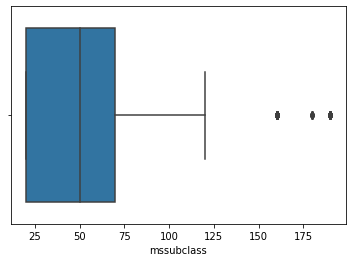

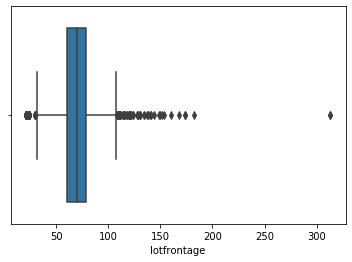

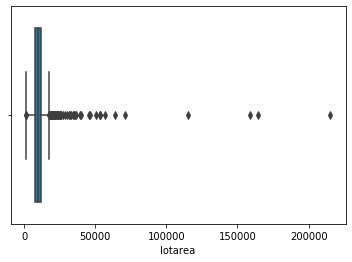

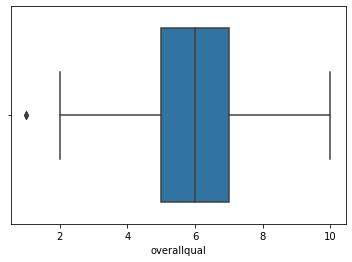

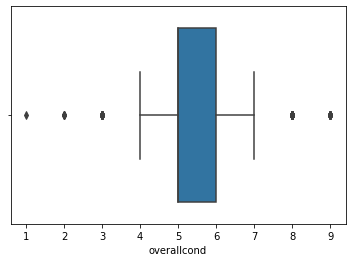

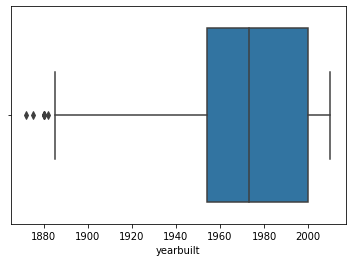

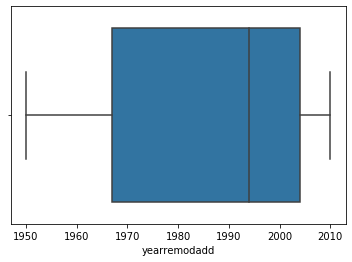

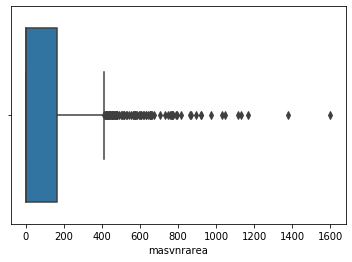

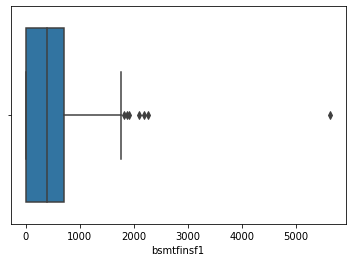

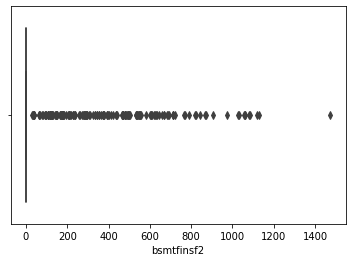

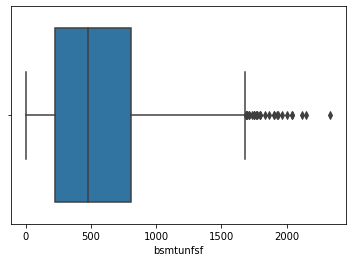

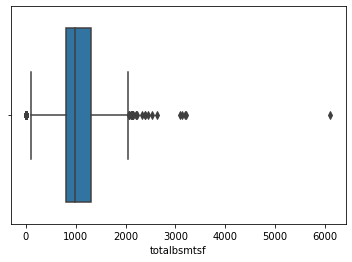

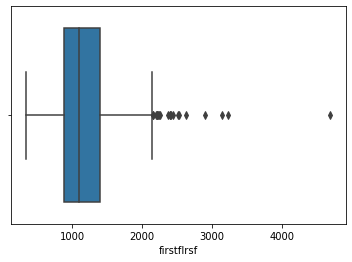

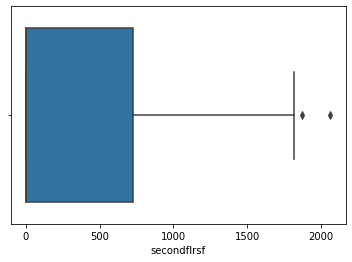

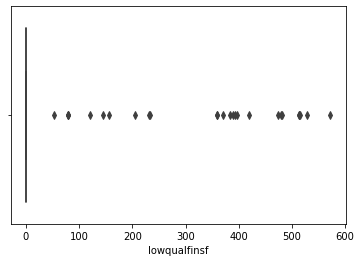

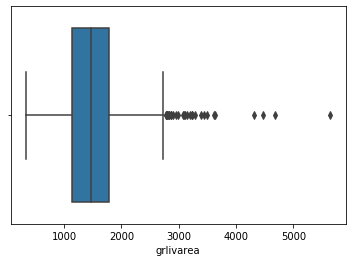

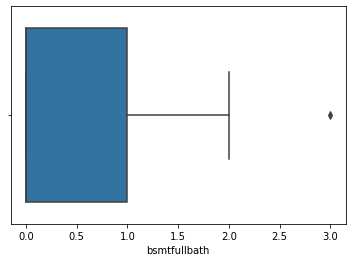

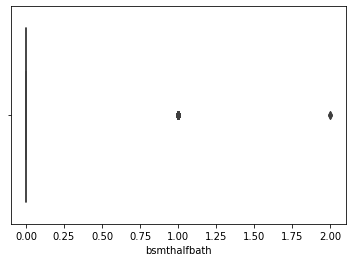

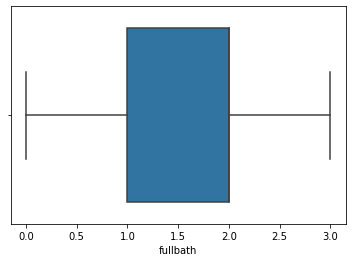

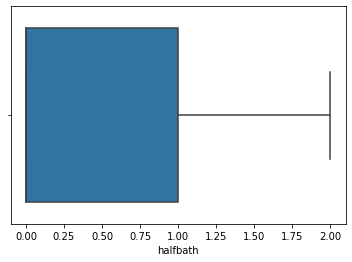

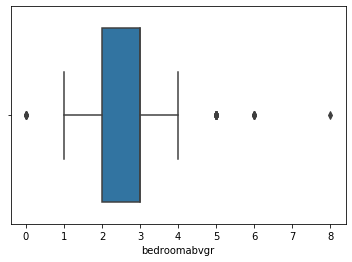

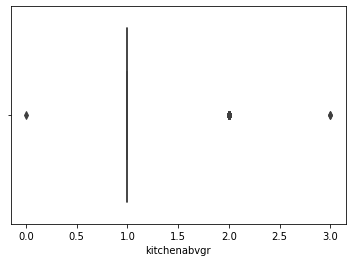

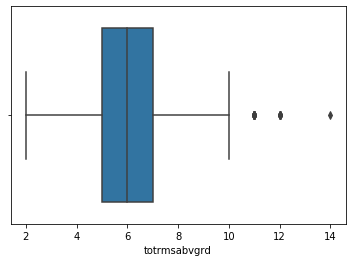

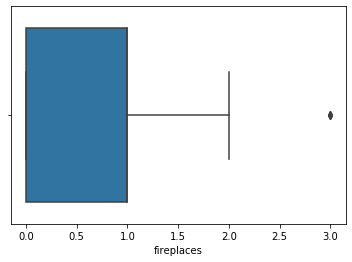

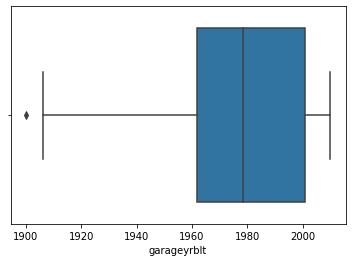

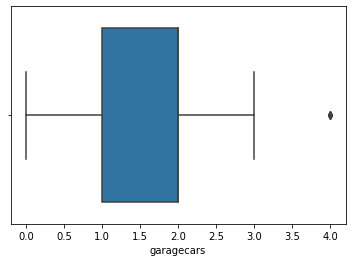

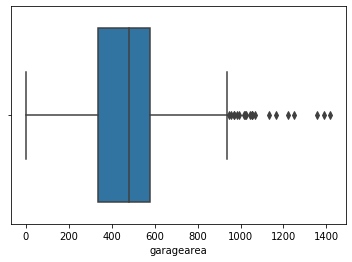

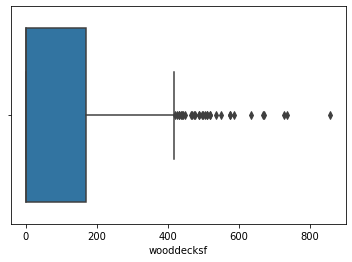

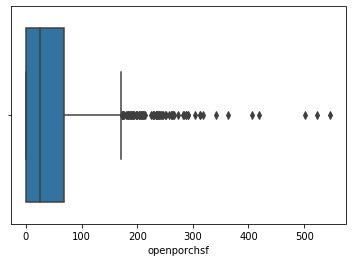

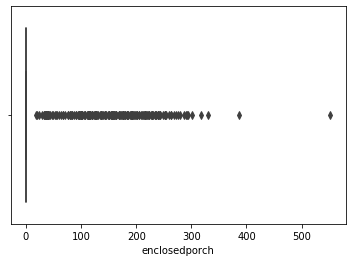

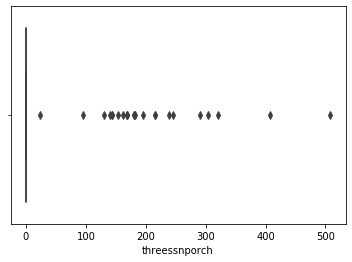

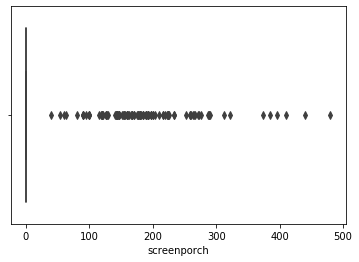

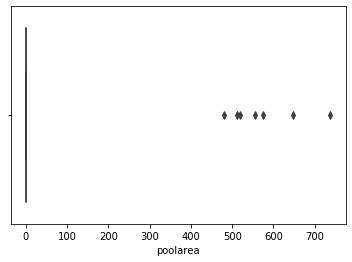

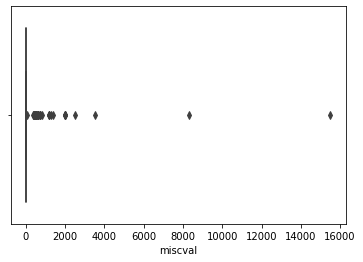

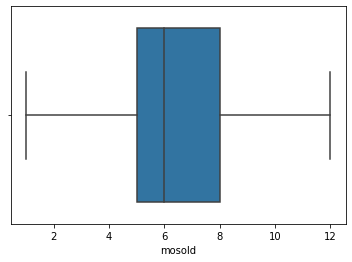

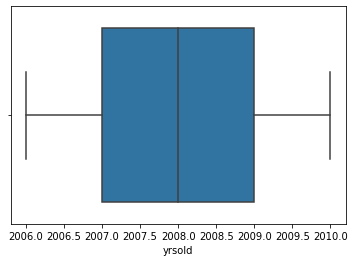

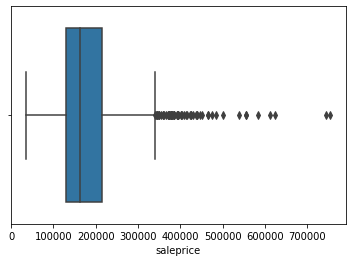

In [13]:
# Explore the numerical columns to check for outliers

columns = ['mssubclass',       
'lotfrontage',      
'lotarea',          
'overallqual',      
'overallcond',      
'yearbuilt',        
'yearremodadd',     
'masvnrarea',
'bsmtfinsf1', 
'bsmtfinsf2', 
'bsmtunfsf',
'totalbsmtsf',
'firstflrsf', 
'secondflrsf',
'lowqualfinsf',
'grlivarea',
'bsmtfullbath',
'bsmthalfbath',
'fullbath',
'halfbath',
'bedroomabvgr',
'kitchenabvgr',
'totrmsabvgrd',
'fireplaces',
'garageyrblt',
'garagecars',
'garagearea',
'wooddecksf',
'openporchsf',
'enclosedporch',
'threessnporch',
'screenporch',
'poolarea',
'miscval',
'mosold',
'yrsold',
'saleprice']

for column in columns:
    sns.boxplot(houses_df[column])
    plt.show()

While the boxplots appear to show some outliers, none of the values appear to be nonsensical and I don't believe winsorization or other outlier methods are necessary.

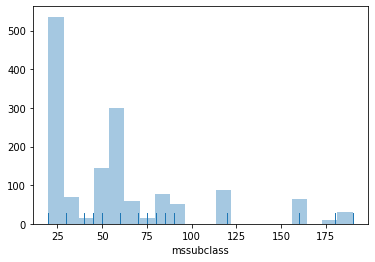

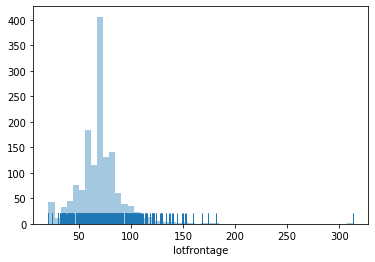

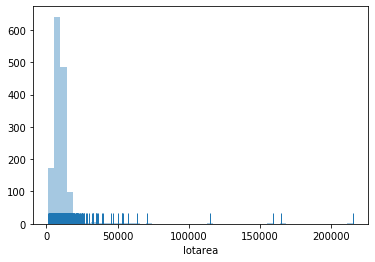

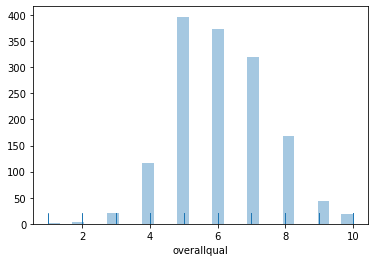

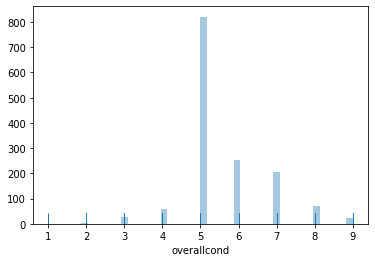

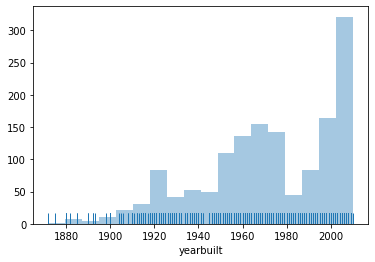

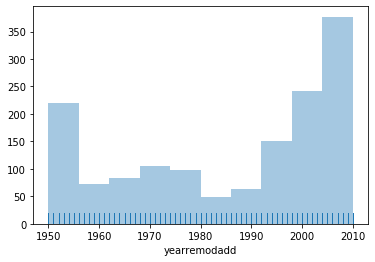

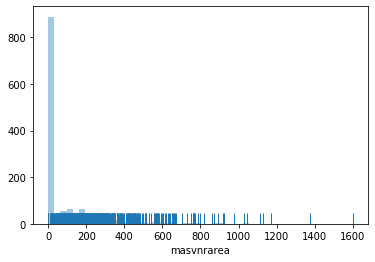

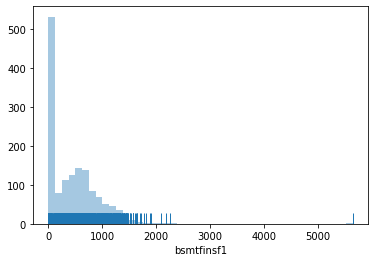

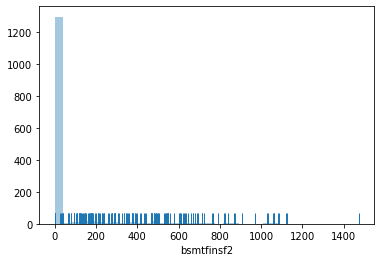

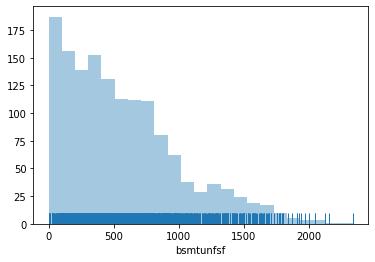

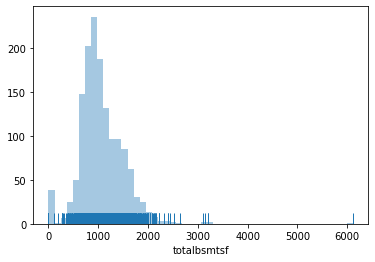

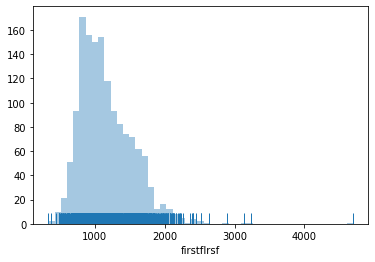

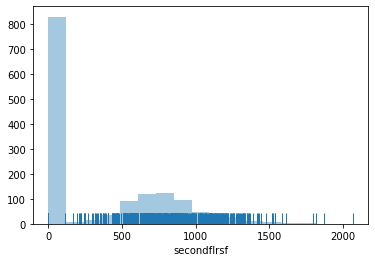

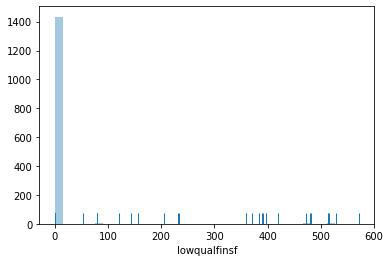

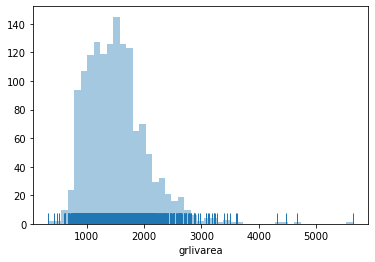

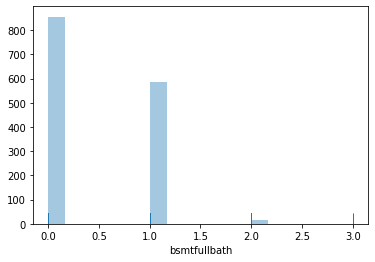

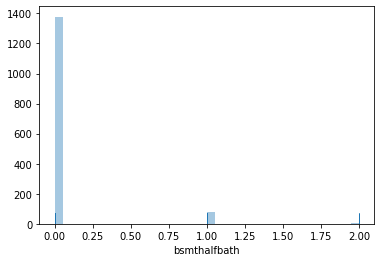

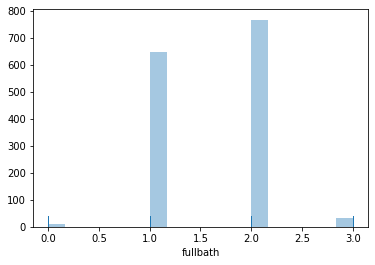

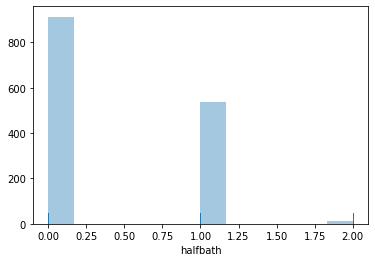

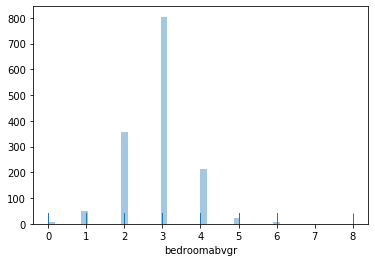

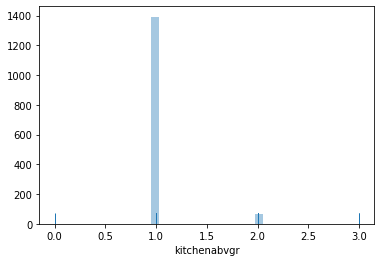

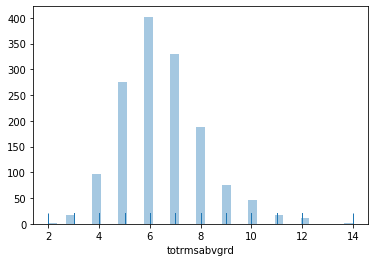

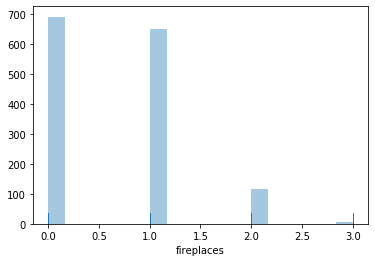

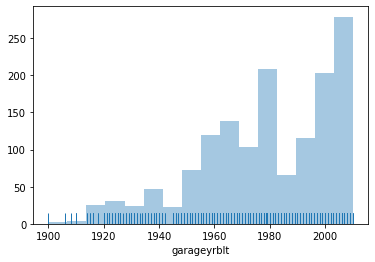

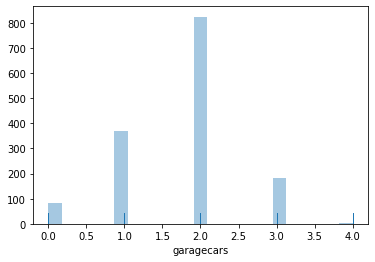

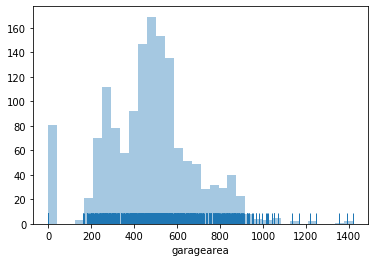

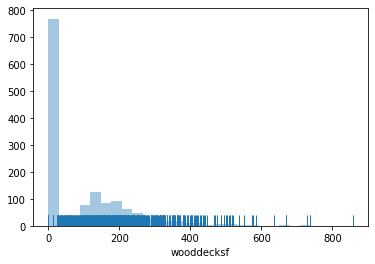

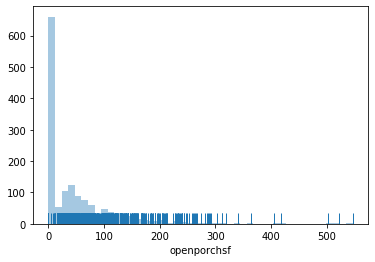

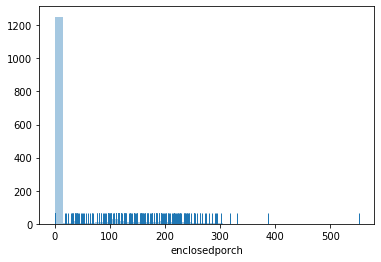

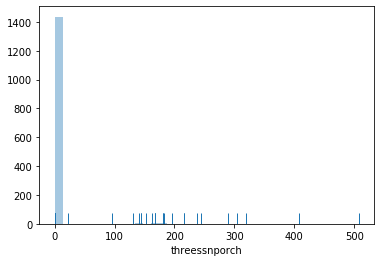

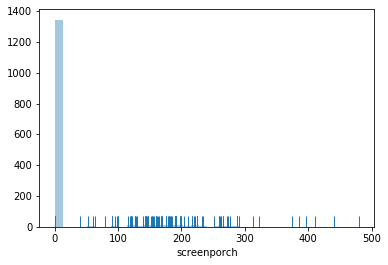

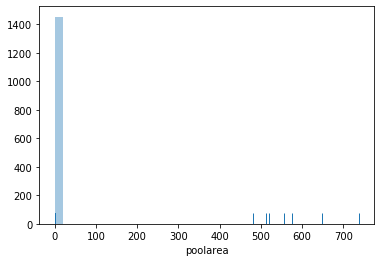

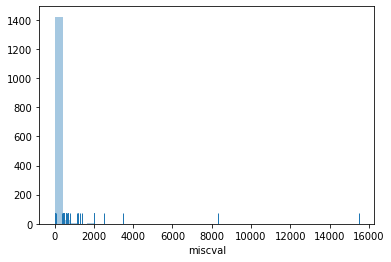

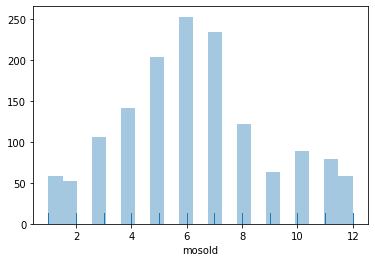

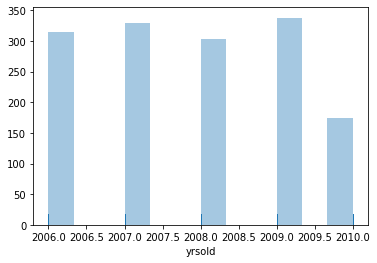

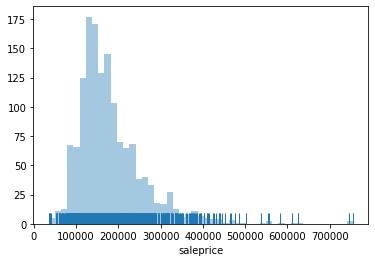

In [14]:
# Data Exploration

for column in columns:
    sns.distplot(houses_df[column],kde=False, rug=True)
    plt.show()

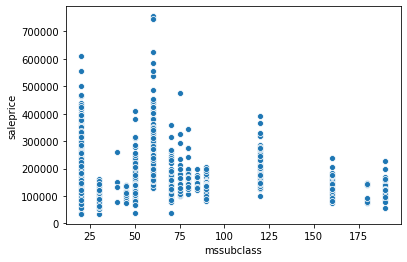

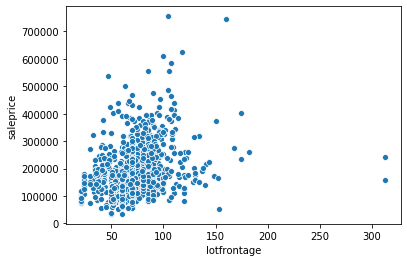

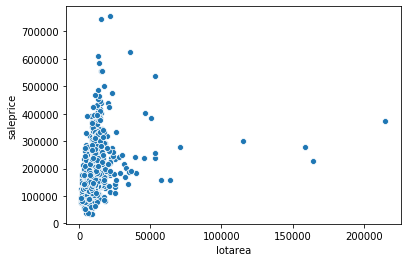

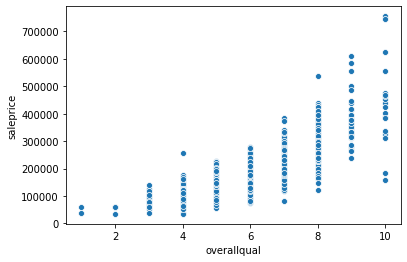

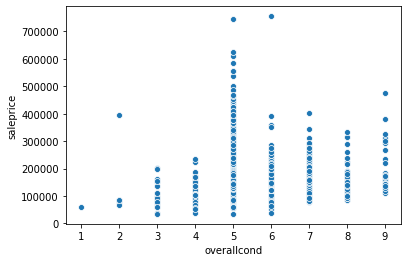

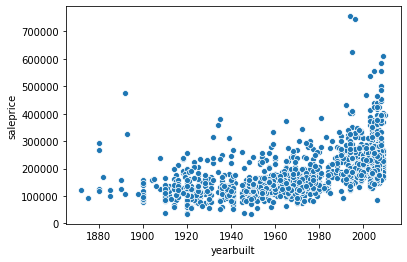

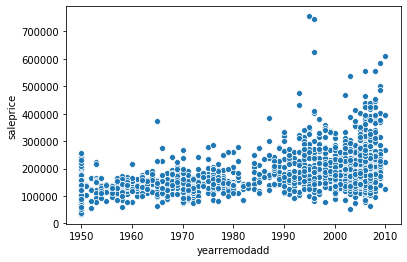

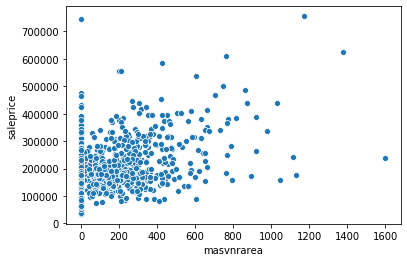

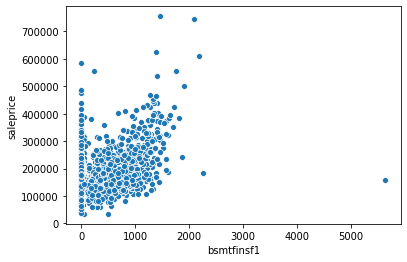

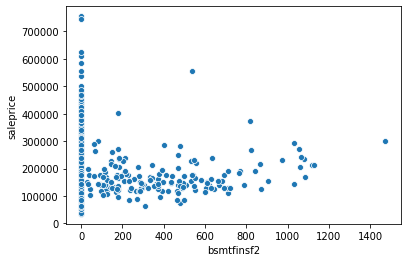

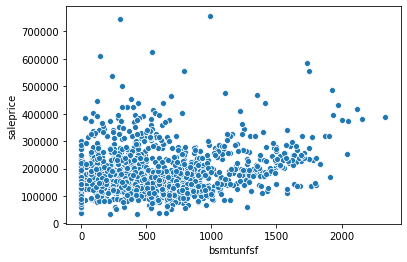

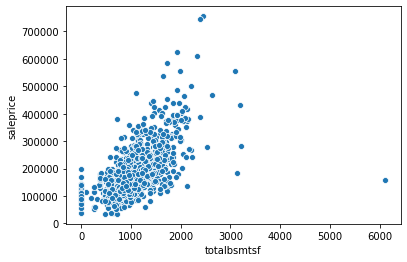

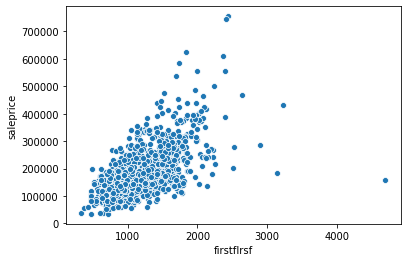

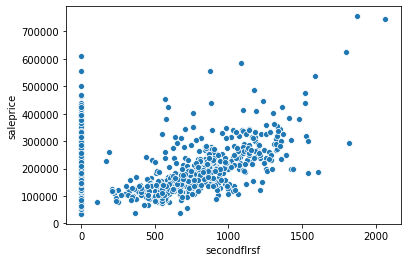

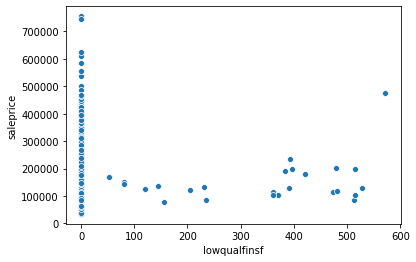

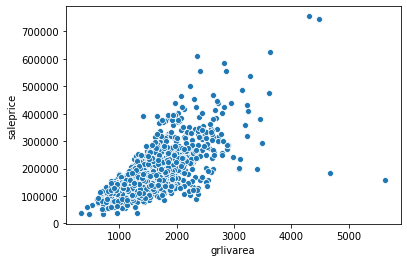

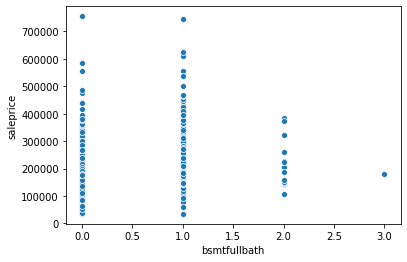

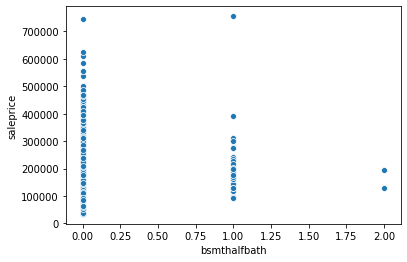

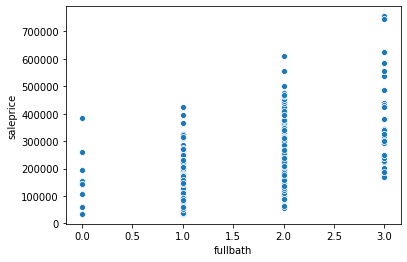

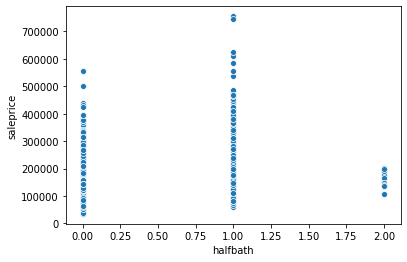

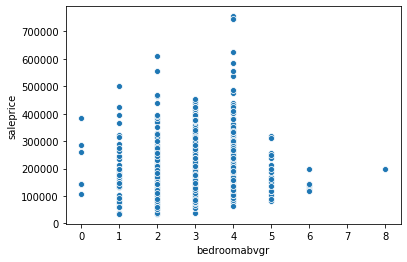

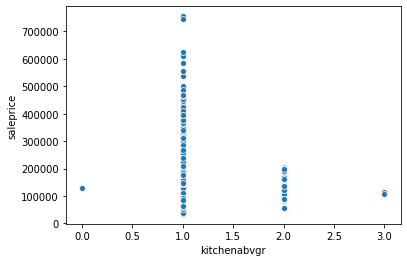

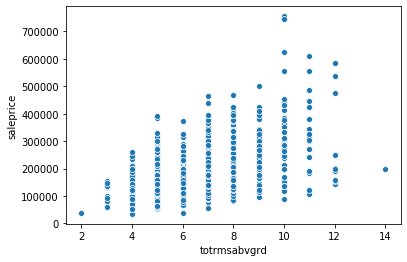

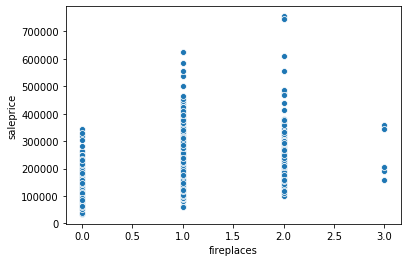

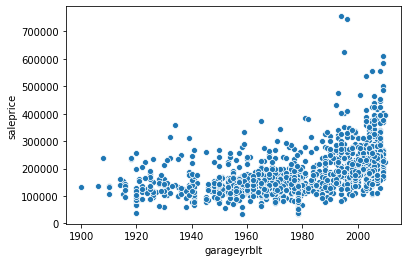

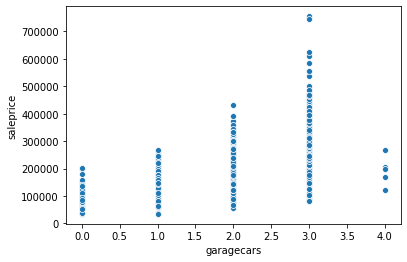

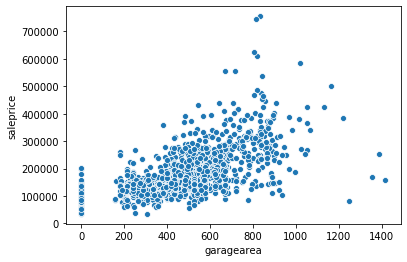

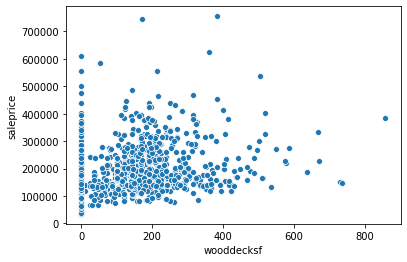

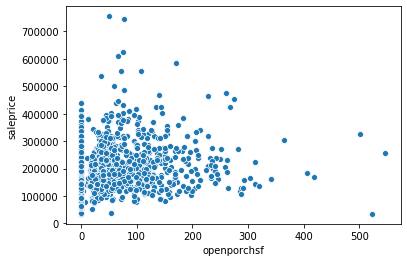

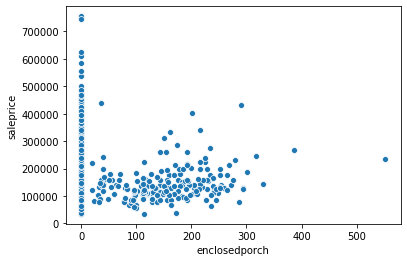

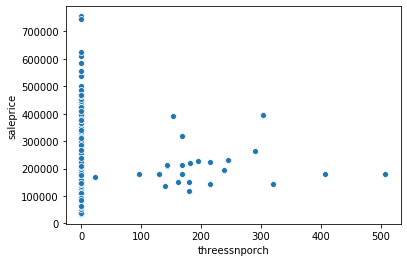

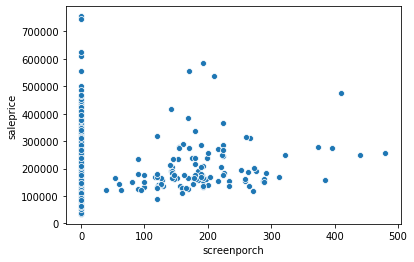

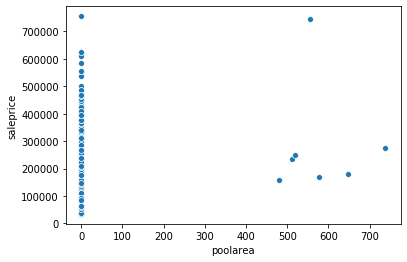

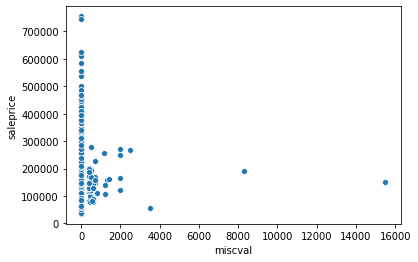

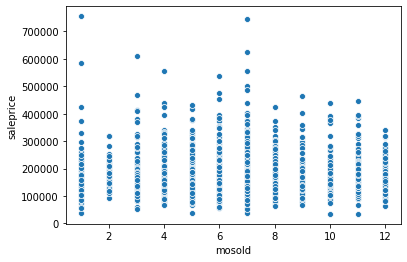

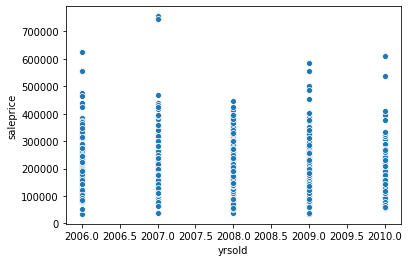

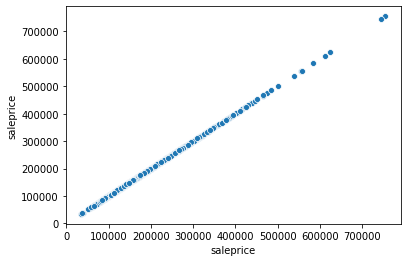

In [15]:
#Inspect the relationship between variables and target variable 'saleprice'
for column in columns:
    sns.scatterplot(houses_df[column], houses_df['saleprice'])
    plt.show()

In [16]:
houses_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.178699,0.215828,...,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
lotarea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.051071,0.023573,0.178699,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
bsmtfinsf1,-0.005024,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


Variables most correlated to saleprice are the Square foot variables, Garage variables, and overall quality. These will be the variables we will proceed forward with in the feature engineering section.

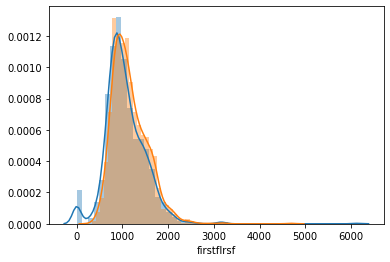

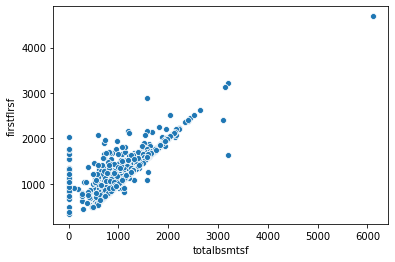

In [17]:
#Intuition tells us that there is probably a relationship with first floor SF and basement SF. Let's plot the distributions to see if they are similar.
sns.distplot(houses_df['totalbsmtsf'])
sns.distplot(houses_df['firstflrsf'])
plt.show()

sns.scatterplot(x=houses_df['totalbsmtsf'],y=houses_df['firstflrsf'])
plt.show()

In [18]:
#It does appear the variables are similar in distribution and we will combine them to make a new variable.
houses_df['firstandbsmtsf'] = houses_df['totalbsmtsf'] + houses_df['firstflrsf']

In [27]:
# Decision Tree
X = houses_df[['overallqual','firstandbsmtsf','grlivarea','garagecars','garagearea']]
Y = houses_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 

from sklearn import tree
from sklearn import metrics
from IPython.display import Image
import pydotplus
import graphviz

# Initialize tree
decision_tree = tree.DecisionTreeRegressor()

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)


In [33]:
print("Accuracy:",decision_tree.score(X_test, y_test))


Accuracy: 0.7522329435802805


In [35]:
# Let's try a Random Forest model.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor()

param_grid = { 'max_depth':range(3,7),'n_estimators':[100,200,300,400,500],
                'bootstrap':[True,False]}

forest_grid = GridSearchCV(estimator, param_grid, cv=5, scoring = 'neg_mean_squared_error',verbose=0,n_jobs=-1)
forest_grid.fit(X_train, y_train)
y_pred = forest_grid.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error of the prediction:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Income in Dataset:', np.mean(Y))
print('The Random Forest Regressor is predicting the median household income at {}%'.format(100*(1 - (metrics.mean_absolute_error(y_test, y_pred))/np.mean(Y))))
print('Root Mean Squared Error of the prediction:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
Forest_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(RandomForestRegressor.score)

Mean Absolute Error of the prediction: 19309.014083847673
Mean Income in Dataset: 180921.19589041095
The Random Forest Regressor is predicting the median household income at 89.32738975728213%
Root Mean Squared Error of the prediction: 29072.667156984135
<function RegressorMixin.score at 0x1a24f22620>


89%, which is much better than the regular Decision tree's accuracy of 75%.